# Sentiment Analysis of Yelp Reviews
## Mark Young
## 12/4/2024
### Question: How do yelp reviewers feel about Thai restraunts in or near Succasunna, NJ?
### Solution: Using the yelp fusion API, I gathered reviews on local restraunts. I determined the sentiment of the reviews and identified common words used. The reviews were cleaned, analyzed, and visualized.

### Imports

In [1]:
import requests
import yelpkeys  # file where client_id and api_key is defined with user's private app information
import pandas as pd
import json
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from __future__ import print_function

import argparse
import pprint
import sys
import urllib

try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

In [2]:
API_KEY= yelpkeys.api_key
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

#### API constants

In [3]:
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.

#### Defaults

In [4]:
DEFAULT_TERM = 'Thai'
DEFAULT_LOCATION = 'Succasunna, NJ'
SEARCH_LIMIT = 20

#### Methods

In [5]:
def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

### Now I'm going to query the yelp API to pull reviews from twenty local restruants.

In [6]:
response = search(API_KEY,DEFAULT_TERM, 'Succasunna, NJ')

Querying https://api.yelp.com/v3/businesses/search ...


#### These are the restruants

In [7]:
response

{'businesses': [{'id': 'dudzDBpyh4ltKwmoJPJxfg',
   'alias': 'thai-kitchen-chester',
   'name': 'Thai Kitchen',
   'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/OMwJV52OIIHhfzDJ9n2QNQ/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/thai-kitchen-chester?adjust_creative=istl9jgw2i0Hp64EIdomvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=istl9jgw2i0Hp64EIdomvQ',
   'review_count': 216,
   'categories': [{'alias': 'thai', 'title': 'Thai'}],
   'rating': 4.1,
   'coordinates': {'latitude': 40.7780145423332,
    'longitude': -74.6985394849321},
   'transactions': ['delivery'],
   'price': '$$',
   'location': {'address1': '320 US Hwy 206 S',
    'address2': '',
    'address3': '',
    'city': 'Chester',
    'zip_code': '07930',
    'country': 'US',
    'state': 'NJ',
    'display_address': ['320 US Hwy 206 S', 'Chester, NJ 07930']},
   'phone': '+19088799800',
   'display_phone': '(908) 879-9800',
   'distance': 8682.290133240007},
  {'id':

### Here I'm pulling the individual reveiews from the businesses and determining their sentiment. 
#### I'm using textblob and NaiveBayesAnalyzer and counting how many results are positive, negative, or neutral

In [10]:
positive_count = 0
neutral_count = 0
negative_count = 0

positive_countNBA = 0
neutral_countNBA = 0
negative_countNBA = 0

for business in response['businesses']:
    print('Business Name: ' + business['name'])
    print('Rating: ' + str(business['rating']))
    print('Review Count: ' + str(business['review_count']))
    print('Reviews: ')
    
    BUS_REVIEW = '/v3/businesses/{}/reviews'.format(business['id'])
    reviews = request(API_HOST, BUS_REVIEW, API_KEY)

    if 'reviews' in reviews:
        for review in reviews['reviews']:
            print(' - ' + review['text'])
            blob_NBA = TextBlob(review['text'], analyzer=NaiveBayesAnalyzer())
            sentiment_NBA = blob_NBA.sentiment.classification
            if sentiment_NBA == 'pos':
                print('    Sentiment (NaiveBayes): Positive')
                positive_countNBA += 1
            elif sentiment_NBA == 'neg':
                print('    Sentiment (NaiveBayes): Negative')
                negative_countNBA += 1
            else:
                print('    Sentiment (NaiveBayes): Neutral')
                neutral_countNBA += 1
            blob = TextBlob(review['text'])
            sentiment = blob.sentiment.polarity
            if sentiment > 0:
                print('    Sentiment (Polarity): Positive')
                positive_count += 1
            elif sentiment < 0:
                print('    Sentiment (Polarity): Negative')
                negative_count += 1
            else:
                print('    Sentiment (Polarity): Neutral')
                neutral_count += 1       
            print('\n================\n\n\n')
    else:
        print("    No reviews available for this business.")
        print('\n================\n\n\n')

Business Name: Thai Kitchen
Rating: 4.1
Review Count: 216
Reviews: 
Querying https://api.yelp.com/v3/businesses/dudzDBpyh4ltKwmoJPJxfg/reviews ...
 - This place is a shining light in the Asian food scene.  When you go west of Morristown a lot of places Americanize their recipes but this place is really...
    Sentiment (NaiveBayes): Positive
    Sentiment (Polarity): Positive




 - Always a pleasure to dine at Thai kitchen. I've grazed my way through the menu and just love the duck noodle
    Sentiment (NaiveBayes): Negative
    Sentiment (Polarity): Positive




 - Best Thai food in area! If you like Peking Duck, you will absolutely love the Duck Bun Appetizer. The Bangkok Shrimp is outstanding!
    Sentiment (NaiveBayes): Positive
    Sentiment (Polarity): Positive




Business Name: Hibiscus Island Grill
Rating: 4.1
Review Count: 277
Reviews: 
Querying https://api.yelp.com/v3/businesses/2c_UWLR8qSUEou-Ove_AKg/reviews ...
 - I recently went for a reunion luncheon for about 25 people

### Results using textblob:

In [11]:
print(f"Positive Reviews: {positive_count}")
print(f"Neutral Reviews: {neutral_count}")
print(f"Negative Reviews: {negative_count}")

Positive Reviews: 40
Neutral Reviews: 6
Negative Reviews: 11


### Results using NaiveBayesAnalyzer

In [12]:
print(f"Positive Reviews: {positive_countNBA}")
print(f"Neutral Reviews: {neutral_countNBA}")
print(f"Negative Reviews: {negative_countNBA}")

Positive Reviews: 42
Neutral Reviews: 0
Negative Reviews: 15


#### Now I'll visulaize the two types of sentiment analysis using doughnut charts (courtsey of chatGPT)

### Doughnut chart with texblob

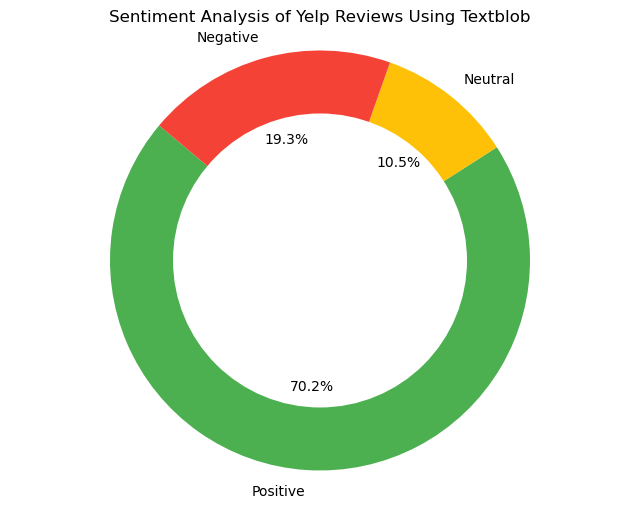

In [13]:
# Sample sentiment counts (replace these with the actual counts from your analysis)
sentiments = ['Positive', 'Neutral', 'Negative']
counts = [positive_count, neutral_count, negative_count]  # Replace these with the actual sentiment counts
colors = ['#4CAF50', '#FFC107', '#F44336']  # Green for positive, yellow for neutral, red for negative

# Create the doughnut chart
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=sentiments, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))

# Add a central circle to create the doughnut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title('Sentiment Analysis of Yelp Reviews Using Textblob')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Doughnut chart with NaiveBayesAnalyzer

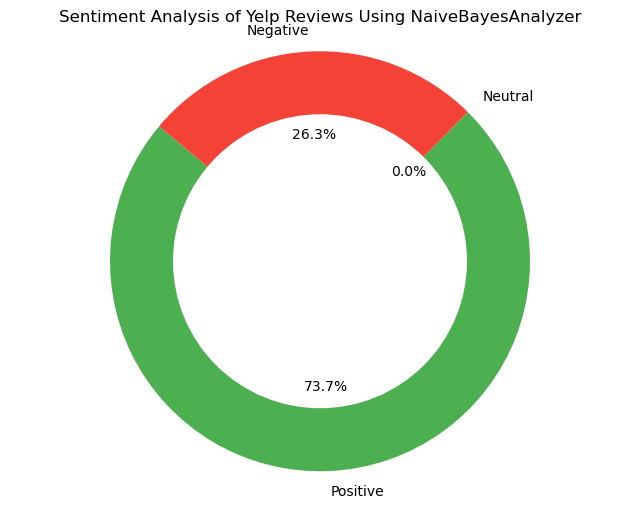

In [14]:
# Sample sentiment counts (replace these with the actual counts from your analysis)
sentiments = ['Positive', 'Neutral', 'Negative']
counts = [positive_countNBA, neutral_countNBA, negative_countNBA]  # Replace these with the actual sentiment counts
colors = ['#4CAF50', '#FFC107', '#F44336']  # Green for positive, yellow for neutral, red for negative

# Create the doughnut chart
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=sentiments, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))

# Add a central circle to create the doughnut shape
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title('Sentiment Analysis of Yelp Reviews Using NaiveBayesAnalyzer')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Common Words
#### I'm determining what the most common words in the review are.
#### To do that, I'm putting all the words in the reviews into a list, not including stopwords. The 20 most common are put into a wordcloud

In [24]:
stop_words = set(stopwords.words('english'))
all_words = []
for business in response['businesses']:
    BUS_REVIEW = '/v3/businesses/{}/reviews'.format(business['id'])
    reviews = request(API_HOST, BUS_REVIEW, API_KEY)
    if 'reviews' in reviews:
        for review in reviews['reviews']:
            words = review['text'].lower().split()
            filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
            all_words.extend(filtered_words)
    else:
        print(f"No reviews found for {business['name']}.")

Querying https://api.yelp.com/v3/businesses/dudzDBpyh4ltKwmoJPJxfg/reviews ...
Querying https://api.yelp.com/v3/businesses/2c_UWLR8qSUEou-Ove_AKg/reviews ...
Querying https://api.yelp.com/v3/businesses/XFFMdPA2Bq1LfFPn0W7XGA/reviews ...
Querying https://api.yelp.com/v3/businesses/JEb5LNqB-FtItvrFD7HYcg/reviews ...
Querying https://api.yelp.com/v3/businesses/6c22qN9cUUa1CWTwoitPXQ/reviews ...
Querying https://api.yelp.com/v3/businesses/M7v7DHOZ1bhVVDGqybomFA/reviews ...
Querying https://api.yelp.com/v3/businesses/qu2Xw_OpJmCRmh0LrtyKkg/reviews ...
Querying https://api.yelp.com/v3/businesses/HPmvwgs5SrF5zWSVzyglQA/reviews ...
Querying https://api.yelp.com/v3/businesses/Pl5XVqzudRh7yKqO_YJbQw/reviews ...
Querying https://api.yelp.com/v3/businesses/v7E5VLXf6t9-j4GFWGiWyA/reviews ...
Querying https://api.yelp.com/v3/businesses/WeSb7p4zl9iGlsO0YHl1aA/reviews ...
Querying https://api.yelp.com/v3/businesses/kKquuVhYJR55HgxgrqnsHA/reviews ...
Querying https://api.yelp.com/v3/businesses/aEGHnptR

In [25]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=20, background_color='white').generate(' '.join(all_words))

### Here is a wordcloud of the 20 most common words in reviews that I analyzed (courtsey of chatGPT)

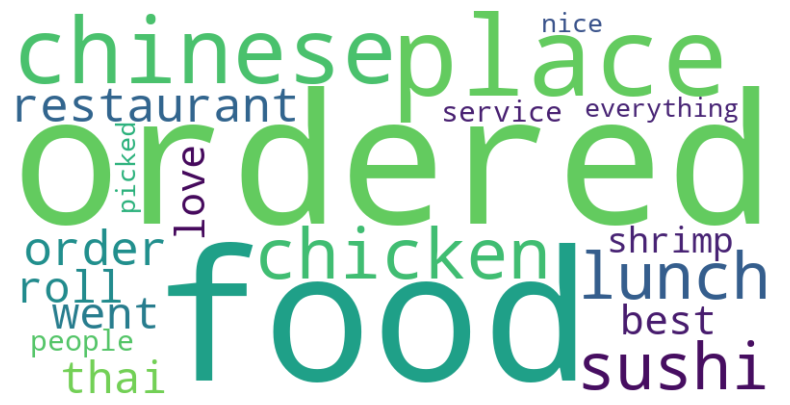

In [26]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()